# Step 1: Load the label settings for each object

In [1]:
from mrcnn.config import Config
from mrcnn import model as modellib
import numpy as np
import cv2

# load the class label names from disk, one label per line
classes = open("coco/coco_labels.txt").read().strip().split("\n")
count = len(classes)

# generate visually distinct colors for each class label
colors = [tuple(cv2.cvtColor(np.array([[[180*i//count,255,255]]],np.uint8),cv2.COLOR_HSV2BGR)[0,0]) for i in range(count)]
colors = [(int(a[0]),int(a[1]),int(a[2])) for a in colors]

Using TensorFlow backend.


# Step 2: Initialize the prediction layer

In [2]:
class SimpleConfig(Config):
    # give the configuration a recognizable name
    NAME = "coco_inference"
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # number of classes 
    NUM_CLASSES = count

# initialize the inference configuration
config = SimpleConfig()

# initialize the Mask R-CNN model for inference and then load the weights
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='coco')
model.load_weights("coco/mask_rcnn_coco.h5", by_name=True)

Instructions for updating:
Use `tf.cast` instead.


# Step 3: Run the normal implementation with all the layers

Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

Total time of function execution:  10.428970336914062


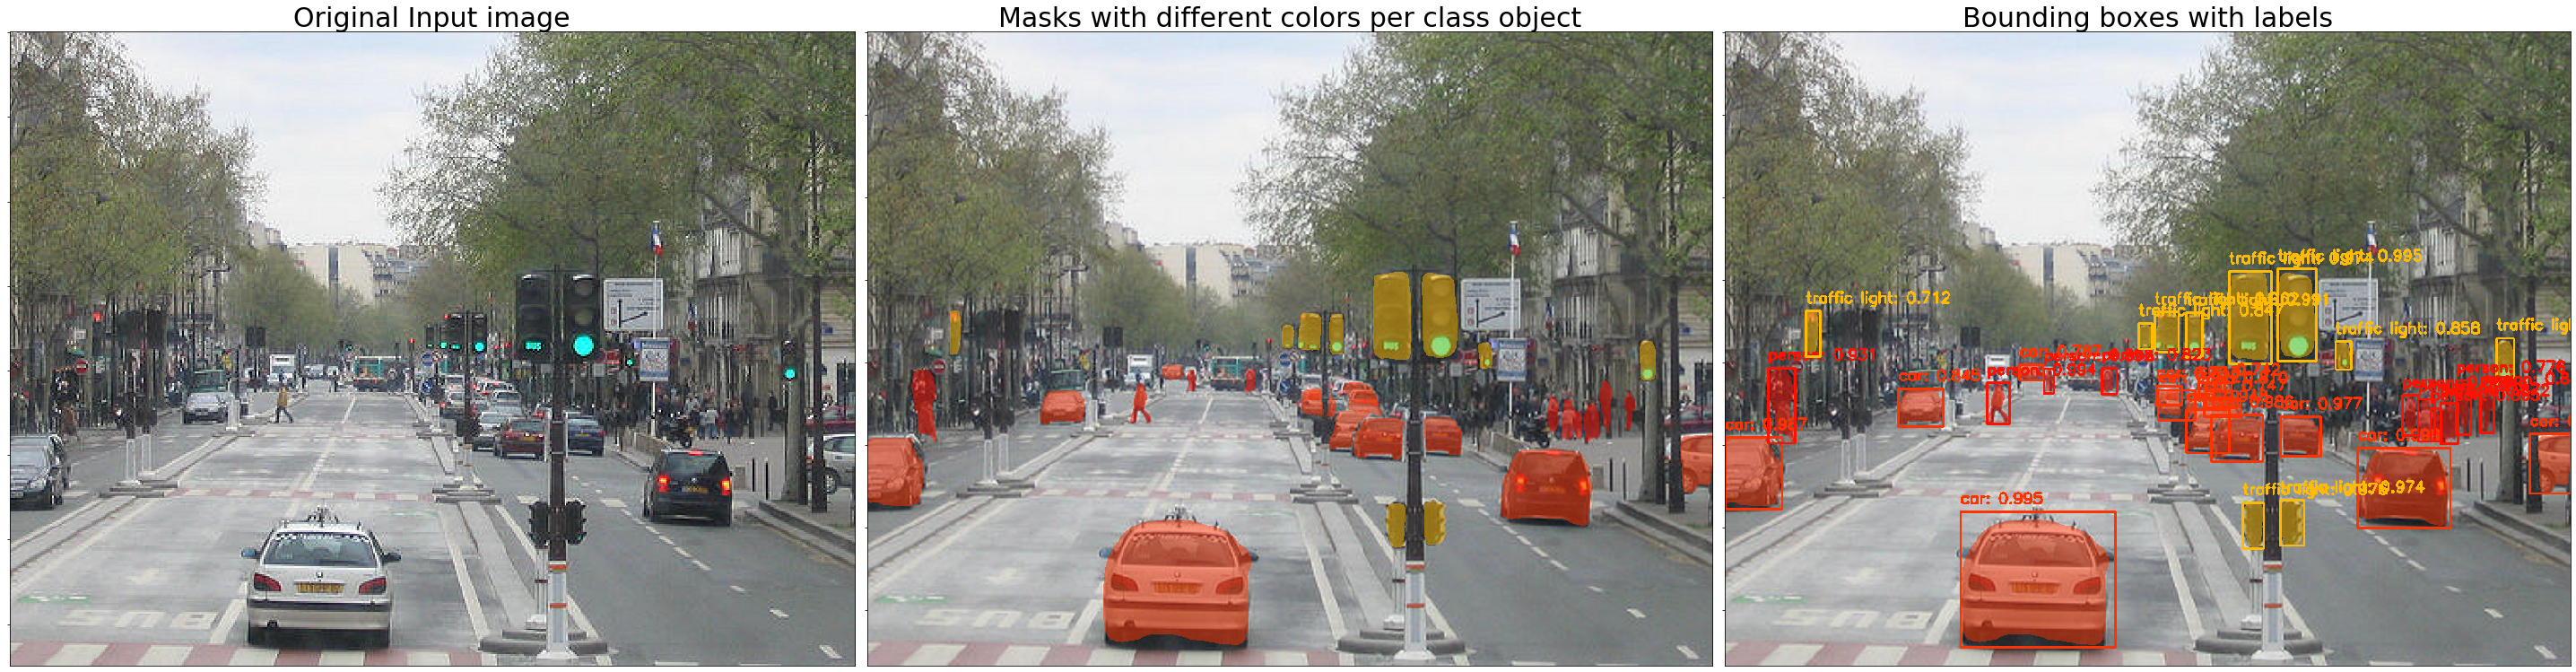

In [3]:
import matplotlib.pyplot as plt
import time

def process(img_path, width=1024, sc = False, crop = False, write = False):
    
    # Time added for Neha
    start = time.time()
    
    # Save original for comparison (did it for later plots)
    orig = cv2.imread(img_path)
    
    w,h,c = orig.shape

    # load the input image, convert it from BGR to RGB channel and resize
    image = cv2.imread(img_path)

    image = cv2.resize(image,(width,width*image.shape[0]//image.shape[1]))
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform a forward pass of the network to obtain the results
    out = model.detect([rgb], verbose=1)[0]

    # loop over of the detected object's bounding boxes and masks
    for i in range(0, out["rois"].shape[0]):
        # extract the class ID and mask for the current detection
        class_id = out["class_ids"][i]
        mask = out["masks"][:, :, i]
        
        # visualize the pixel-wise mask of the object
        color = colors[class_id]
        for c in range(3):
            image[:,:,c] = np.where(mask==1, image[:,:,c]//2 + color[c]//2, image[:,:,c])

    test = image.copy()
    
    # loop over the predicted scores and class labels
    for i in range(0, len(out["scores"])):
        class_id = out["class_ids"][i]   
        # extract the bounding box information, class ID, label, predicted probability, and visualization color
        startY, startX, endY, endX = out["rois"][i]
        label = classes[class_id]
        score = out["scores"][i]
        color = colors[class_id]        
        
        # draw the bounding box, class label, and score of the object        
        x = cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.3f}".format(label, score)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(image, text, (startX,y), 0, 0.6, color, 2)

    # save the output image
    ####################################
    # ALL NEW STUFF BELOW ADDED BY ENO #
    ####################################
    if write:
        cv2.imwrite(img_path + "_result.png", image)
    
    print("\nTotal time of function execution: ", (time.time() - start))
    
    # display the plots for this section
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (40,40))
    axes[0].tick_params(
    axis='both',       # changes apply to the both axes
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft = False)
    
    axes[1].tick_params(
    axis='both',       # changes apply to the both axes
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft = False)
    
    axes[2].tick_params(
    axis='both',       # changes apply to the both axes
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft = False)
    
    
    axes[0].imshow(cv2.cvtColor(orig, cv2.COLOR_RGB2BGR))
    axes[1].imshow(cv2.cvtColor(test, cv2.COLOR_RGB2BGR))
    axes[2].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
    plt.sca(axes[0])
    plt.title('Original Input image', fontsize = 30)
    plt.sca(axes[1])
    axes[1].set_title('Masks with different colors per class object', fontsize= 30)
    plt.sca(axes[2])
    axes[2].set_title('Bounding boxes with labels', fontsize= 30)
    fig.tight_layout()
    fig = plt.show()
     
process("img.jpg", 1024, True, False, True)

# Step 4: Modify above to filter for one object (modifications added by Eno)
## Cropping techniques attempted for this portion
### - numpy index slicing [Bugs with our configuration]
### - numpy masking [Bugs with our configuration]
### - Image.crop from PIL [The cropped image was in the incorrect area/axis]
### - skimage.util.crop function [Bugs with our configuration]
### - tensorflow.image.crop_to_bounding_box [Desired output found]

Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

Total processed traffic lights:  10


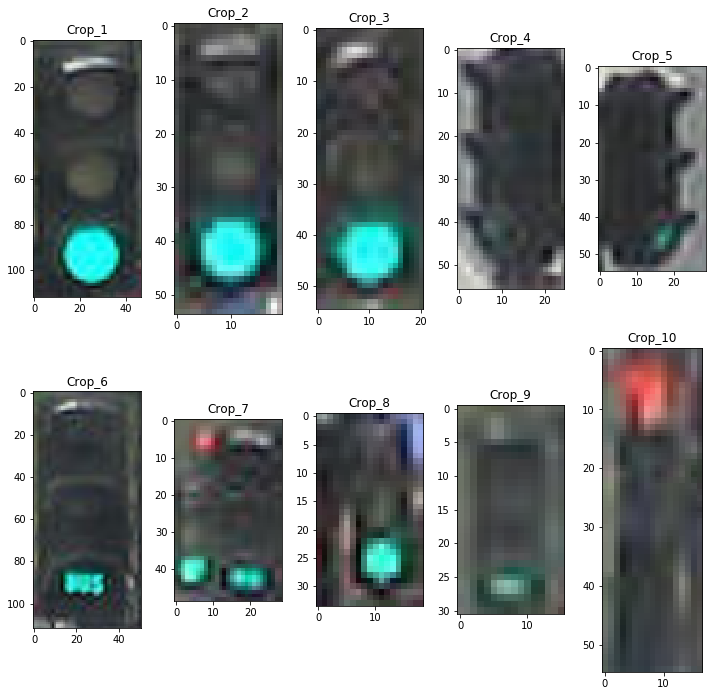

Failed to make new directories or they are already present!


In [4]:
from mrcnn.config import Config
from mrcnn import model as modellib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os

# load the class label names from disk, one label per line
classes = open("coco/coco_labels.txt").read().strip().split("\n")
count = len(classes)

# generate visually distinct colors for each class label
colors = [tuple(cv2.cvtColor(np.array([[[180*i//count,255,255]]],np.uint8),cv2.COLOR_HSV2BGR)[0,0]) for i in range(count)]
colors = [(int(a[0]),int(a[1]),int(a[2])) for a in colors]

class SimpleConfig(Config):
    # give the configuration a recognizable name
    NAME = "coco_inference"
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # number of classes 
    NUM_CLASSES = count

# initialize the inference configuration
config = SimpleConfig()

# initialize the Mask R-CNN model for inference and then load the weights
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='coco')
model.load_weights("coco/mask_rcnn_coco.h5", by_name=True)

specific_class = 10

def process(img_path, width=1024, sc = False, crop = False, write = False):
        
    # save original for comparison
    orig = cv2.imread(img_path)    
    
    w,h,c = orig.shape

    # load the input image, convert it from BGR to RGB channel and resize
    image = cv2.imread(img_path)

    image = cv2.resize(image,(width,width*image.shape[0]//image.shape[1]))
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    nimg = image.copy()

    # perform a forward pass of the network to obtain the results
    out = model.detect([rgb], verbose=1)[0]

    # loop over of the detected object's bounding boxes and masks
    for i in range(0, out["rois"].shape[0]):
        # extract the class ID and mask for the current detection
        class_id = out["class_ids"][i]
        if sc and class_id != specific_class:
            continue
        mask = out["masks"][:, :, i]
        
        # visualize the pixel-wise mask of the object
        color = colors[class_id]
        for c in range(3):
            image[:,:,c] = np.where(mask==1, image[:,:,c]//2 + color[c]//2, image[:,:,c])

    test = image.copy()
    
    coll = []
    # loop over the predicted scores and class labels
    for i in range(0, len(out["scores"])):
        startY, startX, endY, endX = out["rois"][i]
        class_id = out["class_ids"][i]
        if sc and class_id != specific_class:
            continue        
        # extract the bounding box information, class ID, label, predicted probability, and visualization color
        
        label = classes[class_id]
        score = out["scores"][i]
        color = colors[class_id]        
        
        # draw the bounding box, class label, and score of the object        
        x = cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.3f}".format(label, score)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(image, text, (startX,y), 0, 0.6, color, 2)
        
        if crop:
            
            height,width,_ = nimg.copy().shape

            cropped = tf.image.crop_to_bounding_box(nimg.copy(), startY, startX, endY - startY, endX - startX)
            
            coll.append(np.array(cropped.numpy()))
        

    print("\nTotal processed traffic lights: ", len(coll))
    
    # customized plots for this section
    fig, axes = plt.subplots(nrows = 2, ncols = int(len(coll)/2) , figsize=(10, 10))
    
    # generate titles' names
    titlenames = []
    for i in range(0, len(coll)):
        titlenames.append("Crop_" + str(i+1))
    
    #load images
    count = 0
    for i in range(0, 2):
        for j in range(0, int(len(coll)/2)):
            axes[i][j].imshow(Image.fromarray(cv2.cvtColor(coll[count], cv2.COLOR_RGB2BGR)))
            plt.sca(axes[i][j])
            plt.title(titlenames[count])
            count +=1
    
    #tighten everything
    fig.tight_layout()
    fig = plt.show()
    
    # show the output image
    if write:
        keep = os.getcwd()
        #Create the new directories for the image folders
        path1 = '.\\' + "orig_results"
        path2 = '.\\' + "cropped_results"

        try:
            os.mkdir(path1)
            os.mkdir(path2)
        except:
            print("Failed to make new directories or they are already present!")
        
        # orig + bboxes + labels result
        os.chdir(path1)
        cv2.imwrite("results.png", image)
        
        os.chdir(keep)
        os.chdir(path2)
        
        # crops sorted in order
        for i in range(0, len(coll)):
            cv2.imwrite(titlenames[i] + '.png', coll[i])
            
        # revert back to root
        os.chdir(keep)
                           
#process("img.jpg", 1024, True, False, True)
#process("img.jpg", 1024, True, True)
process("img.jpg", 1024, True, True, True)

# Step 5: Standardize the images for analysis

Already at directory.


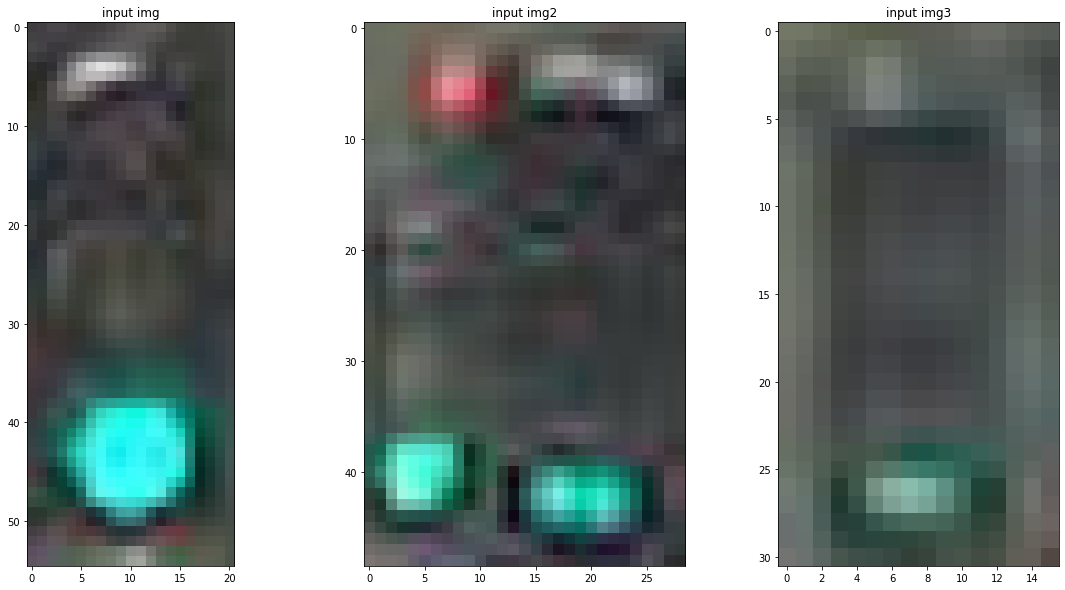

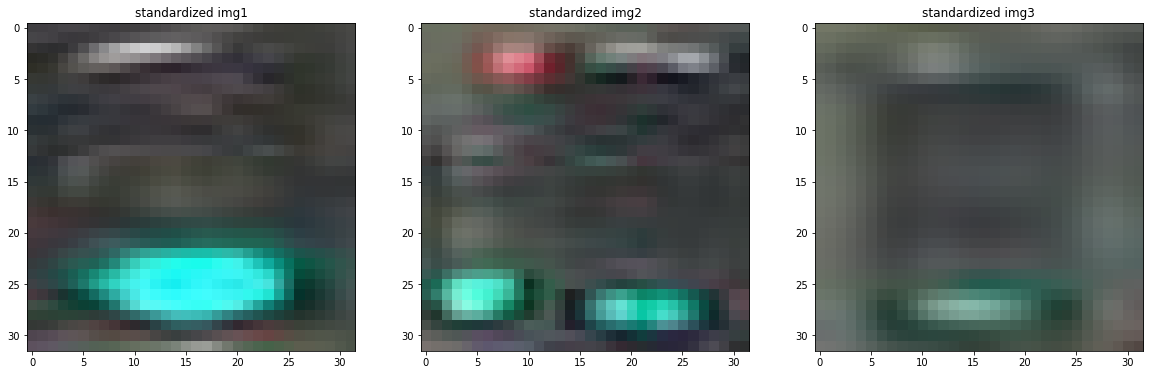

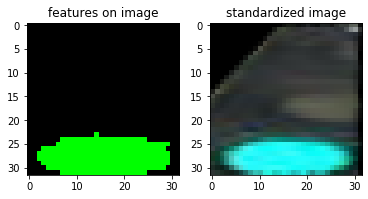

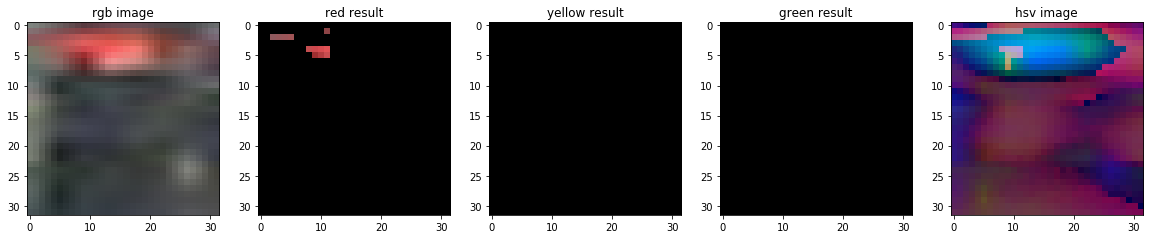

The COLOR of the image is: Red


In [11]:
# calculate the average of a lower bounded array of numbers
# for classifying traffic light images this lower bound was 
# set to 0.1 radians.
def average(array, lBound=0.1, uBound=0.6):
    new_array = []
    for i,row in enumerate(array):
        for j,cell in enumerate(row):
            if (cell >= lBound and cell < uBound):
                new_array.append(cell)
    if len(new_array) == 0:
        return 0
    else:
        return sum(new_array)/len(new_array)
    
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

# Use a sobel image filter and return the magnitude and angles vectors
# for the image
# reference : https://www.programcreek.com/python/example/89325/cv2.Sobel
def sobel_filter(image):
    # sobel filter x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    # absolute the gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # get magnitude array & angle array
    mag, ang = to_polar_coords(abs_sobelx, abs_sobely)
    
     # scale values to 8 bit
    scale_factor = np.max(mag)/255
    mag = (mag/scale_factor).astype(np.uint8)
    
    return mag, ang

def getBoundingBox(img_thres):
    # ref : https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(img_thres > 0))
    rect = cv2.minAreaRect(coords)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    angle = rect[-1]
    # handle the angle to get correct output
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    
    return box, angle
            
    
def rectanglemask(img, box):
    # transpose as box is flipped
    mask_img = cv2.transpose(np.zeros_like(img))
    cv2.drawContours(mask_img,[box], 0, (255,255,255), -1)
    mask_img = np.uint8(mask_img)
    ret, mask = cv2.threshold(mask_img,1,255,cv2.THRESH_BINARY)
    # transpose back
    mask = cv2.transpose(mask)
    return mask

# rotate the image by a specified angle.
# ref: https://www.pyimagesearch.com/2014/01/20/basic-image-manipulations-in-python-and-opencv-resizing-scaling-rotating-and-cropping/
def rotate(image, angle):
    if len(image.shape) > 2:
        h, w, _ = image.shape
    else:
        h, w = image.shape
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h))
    
    return rotated
    
    
# Some of the traffic light images are very skewed. This function attempts to
# center the traffic lights for easier feature extraction. 
# This function filters and image through a sobel image filter extracting magnitude vectors from
# each pixel. These vectors are then filtered and an average image rotation angle is computed
# and returned.
# The magnitude thresold, and angle threshold values were randomly choosen though trail and error.
def getTrafficLightAngle(image, mag_thes=(80, 255), ang_thres=(-np.pi/6, np.pi/6)):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    mag, ang = sobel_filter(gray)
        ### print(average(mag, mag_thes[0], mag_thes[1]))
    
     # threshold between angle values, and magnitude values
    ang_threshold = np.zeros_like(ang)
    above_ang =   (ang > ang_thres[0]) \
                & (ang <= ang_thres[1]) \
                & (mag > mag_thes[0])   \
                & (mag <= mag_thes[1])
    ang_threshold[above_ang] = 1
    
    # mask the thresheld image with the angle image
    masked_ang = np.copy(ang)
    masked_ang[ang_threshold == 0] = 0
    
    h, w = ang_threshold.shape
    # If the thresholding only revelas a few pixels disregard
    # and set angle to zero
    numOfEdges = np.count_nonzero(masked_ang>0)
    if numOfEdges > 80:
        box, angle = getBoundingBox(ang_threshold)
    else:
        angle = 0
        box = np.array([[0, w],
                        [0, 0],
                        [h, 0],
                        [h, w]], np.int32)
    
    return box, angle, masked_ang

###################################
# MODIFICATIONS BEGIN HERE BY ENO #
###################################

try:
    os.chdir('.\\cropped_results')
except:
    print("Already at directory.")

red = cv2.imread("Crop_1.png")
standard_im = np.copy(red)
box, angle, sobel = getTrafficLightAngle(standard_im)
# plt.imshow(sobel)

# create rectangluar mask from edge detection
mask = rectanglemask(sobel, box)
mask = cv2.resize(mask, (red.shape[1], red.shape[0])) 
mask_img = np.copy(red)
#mask image
mask_img = cv2.bitwise_and(red, mask_img,mask = mask)

# rotate image by skew
cnt = rotate(mask, angle)
# get bounding box
x,y,w,h = cv2.boundingRect(cnt)
#rotate masked image & crop
rotated = rotate(mask_img, angle)
cropped = rotated[y:y+h,x:x+w]

'''
print("angle: {}".format(angle))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('image')
ax1.imshow(cv2.cvtColor(red, cv2.COLOR_RGB2BGR))
ax2.set_title('mask')
ax2.imshow(cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR))
ax3.set_title('cropped')
ax3.imshow(cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))
plt.show()'''

# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    ## TODO: Resize image and pre-process so that all "standard" images are the same size  
    box, angle, sobel = getTrafficLightAngle(image)
    
    # create rectangluar mask from edge detection
    mask = rectanglemask(sobel, box)
    mask = cv2.resize(mask, (image.shape[1], image.shape[0])) 
    mask_img = np.copy(image)
    #mask image
    mask_img = cv2.bitwise_and(image, mask_img,mask = mask)

    # rotate image by skew
    cnt = rotate(mask, angle)
    # get bounding box
    x,y,w,h = cv2.boundingRect(cnt)
    #rotate masked image & crop
    rotated = rotate(mask_img, angle)
    cropped = rotated[y:y+h,x:x+w]
    
    #resize to 32 X 32
    standard_im = cv2.resize(cropped, (32, 32))
    
    return standard_im
    

#original red green and blue image
random_img = cv2.imread("Crop_3.png")
random_img2 = cv2.imread("Crop_7.png")
random_img3 = cv2.imread("Crop_9.png")

# show red, yellow, green images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('input img')
ax1.imshow(cv2.cvtColor(random_img, cv2.COLOR_RGB2BGR))
ax2.set_title('input img2')
ax2.imshow(cv2.cvtColor(random_img2, cv2.COLOR_RGB2BGR))
ax3.set_title('input img3')
ax3.imshow(cv2.cvtColor(random_img3, cv2.COLOR_RGB2BGR))
plt.show()
    
#original red green and blue image
std_red = standardize_input(random_img)
std_yellow = standardize_input(random_img2)
std_green = standardize_input(random_img3)

# show red, yellow, green images
f2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('standardized img1')
ax1.imshow(cv2.cvtColor(std_red, cv2.COLOR_RGB2BGR))
ax2.set_title('standardized img2')
ax2.imshow(cv2.cvtColor(std_yellow, cv2.COLOR_RGB2BGR))
ax3.set_title('standardized img3')
ax3.imshow(cv2.cvtColor(std_green, cv2.COLOR_RGB2BGR))
plt.show()

def feature_rgb(rgb_image):
    
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    
    image = np.copy(hsv)
    # green
    lower_green = np.array([80,120,80]) 
    upper_green = np.array([140,255,255])
    #yellow
    lower_yellow = np.array([0,100,120]) 
    upper_yellow = np.array([80,255,255])
    #red
    lower_red = np.array([140,50,20]) 
    upper_red = np.array([180,255,255])
    
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_red = cv2.inRange(hsv, lower_red, upper_red)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    
    masked_image = np.zeros((image.shape[1],image.shape[0],3), np.uint8)
    masked_image[mask_red != 0] = [255, 0, 0]
    masked_image[mask_green != 0] = [0, 255, 0]
    masked_image[mask_yellow != 0] = [0, 0, 255]
        
    return masked_image


testing = cv2.imread("Crop_1.png")

testing = standardize_input(testing)

testing = cv2.cvtColor(testing, cv2.COLOR_RGB2BGR)

feature = feature_rgb(testing)

f3, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('features on image')
ax1.imshow(cv2.cvtColor(feature, cv2.COLOR_RGB2BGR))
ax2.set_title('standardized image')
ax2.imshow(testing)

def findNoneZero(rgb_image):
    rows,cols,_ = rgb_image.shape
    counter = 0
    for row in range(rows):
        for col in range(cols):
            pixels = rgb_image[row,col]
            if sum(pixels)!=0:
                counter = counter+1
    return counter

def red_green_yellow(rgb_image,display):
    '''
    Determines the red , green and yellow content in each image using HSV and experimentally
    determined thresholds. Returns a Classification based on the values
    '''
    hsv = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2HSV)
    sum_saturation = np.sum(hsv[:,:,1])# Sum the brightness values
    area = 32*32
    avg_saturation = sum_saturation / area #find average
    
    sat_low = int(avg_saturation*1.3) #using 1.3 as scale
    val_low = 140
    
    #Green
    lower_green = np.array([70,sat_low,val_low])
    upper_green = np.array([100,255,255])
    green_mask = cv2.inRange(hsv,lower_green,upper_green)
    green_result = cv2.bitwise_and(rgb_image,rgb_image,mask = green_mask)
    
    #Yellow
    lower_yellow = np.array([10,sat_low,val_low])
    upper_yellow = np.array([60,255,255])
    yellow_mask = cv2.inRange(hsv,lower_yellow,upper_yellow)
    yellow_result = cv2.bitwise_and(rgb_image,rgb_image,mask=yellow_mask)
    
    # Red 
    lower_red = np.array([150,sat_low,val_low])
    upper_red = np.array([180,255,255])
    red_mask = cv2.inRange(hsv,lower_red,upper_red)
    red_result = cv2.bitwise_and(rgb_image,rgb_image,mask = red_mask)
    
    if display is True:
        _,ax = plt.subplots(1,5,figsize=(20,10))
        ax[0].set_title('rgb image')
        ax[0].imshow(rgb_image)
        ax[1].set_title('red result')
        ax[1].imshow(red_result)
        ax[2].set_title('yellow result')
        ax[2].imshow(yellow_result)
        ax[3].set_title('green result')
        ax[3].imshow(green_result)
        ax[4].set_title('hsv image')
        ax[4].imshow(hsv)
        plt.show()
    sum_green = findNoneZero(green_result)
    sum_red = findNoneZero(red_result)
    sum_yellow = findNoneZero(yellow_result)
    if sum_red >= sum_yellow and sum_red>=sum_green:
        return "Red"
    if sum_yellow>=sum_green:
        return "Yellow"
    
    return "Green"

testing = cv2.imread("Crop_10.png")
testing = standardize_input(testing)
testing = cv2.cvtColor(testing, cv2.COLOR_RGB2BGR)

value = red_green_yellow(testing, True)

print("The COLOR of the image is:", value)